In [1]:
# from Data Preparation notebook

import re
import nltk
import emoji
import numpy as np
from nltk.tokenize import word_tokenize
from utils2 import get_dict


In [2]:
# from Assignment nb

# Import Python libraries and helper functions (in utils2) 
#import nltk
#from nltk.tokenize import word_tokenize
#import numpy as np
from collections import Counter
from utils2 import sigmoid, get_batches, compute_pca


In [3]:
# Import TensorFlow for neural networks
from tensorflow.keras.layers import Input, Dense  # Importing specific layers and functions
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model  # Importing the Model class


# Data Loading, Cleaning and Tokenization

In [4]:
# Download sentence tokenizer
nltk.data.path.append('.')


In [5]:
# Load, tokenize and process the data
import re                                                           #  Load the Regex-modul
with open('shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data
data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .
data = nltk.word_tokenize(data)                                     #  Tokenize string to words
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens
print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample


Number of tokens: 60976 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


In [6]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.


Size of vocabulary:  5775
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


In [7]:
fdist

FreqDist({'.': 9630, 'the': 1521, 'and': 1394, 'i': 1257, 'to': 1159, 'of': 1093, 'my': 857, 'that': 781, 'in': 770, 'a': 752, ...})

In [8]:
data


['o',
 'for',
 'a',
 'muse',
 'of',
 'fire',
 '.',
 'that',
 'would',
 'ascend',
 'the',
 'brightest',
 'heaven',
 'of',
 'invention',
 '.',
 'a',
 'kingdom',
 'for',
 'a',
 'stage',
 '.',
 'princes',
 'to',
 'act',
 'and',
 'monarchs',
 'to',
 'behold',
 'the',
 'swelling',
 'scene',
 '.',
 'then',
 'should',
 'the',
 'warlike',
 'harry',
 '.',
 'like',
 'himself',
 '.',
 'assume',
 'the',
 'port',
 'of',
 'mars',
 '.',
 'and',
 'at',
 'his',
 'heels',
 '.',
 'leash',
 'in',
 'like',
 'hounds',
 '.',
 'should',
 'famine',
 '.',
 'sword',
 'and',
 'fire',
 'crouch',
 'for',
 'employment',
 '.',
 'but',
 'pardon',
 '.',
 'and',
 'gentles',
 'all',
 '.',
 'the',
 'flat',
 'unraised',
 'spirits',
 'that',
 'have',
 'dared',
 'on',
 'this',
 'unworthy',
 'scaffold',
 'to',
 'bring',
 'forth',
 'so',
 'great',
 'an',
 'object',
 'can',
 'this',
 'cockpit',
 'hold',
 'the',
 'vasty',
 'fields',
 'of',
 'france',
 '.',
 'or',
 'may',
 'we',
 'cram',
 'within',
 'this',
 'wooden',
 'o',
 'the'

# Data Processing

In [9]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)


Size of vocabulary:  5775


In [10]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )


Index of the word 'king' :   2744
Word which has index 2743:   kinds


In [11]:
# Define the 'get_windows' function
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1



In [12]:
# Define the 'word_to_one_hot_vector' function that will include the steps previously seen
def word_to_one_hot_vector(word, word2Ind, V):
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2Ind[word]] = 1
    return one_hot_vector
    

In [13]:
# Print output of 'word_to_one_hot_vector' function for word 'happy'
happy = word_to_one_hot_vector('happy', word2Ind, V)
happy


array([0., 0., 0., ..., 0., 0., 0.])

In [14]:
np.sum(happy)

1.0

In [15]:
# Define the 'context_words_to_vector' function that will include the steps previously seen
def context_words_to_vector(context_words, word2Ind, V):
    context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    return context_words_vectors


In [16]:
# Print output of 'context_words_to_vector' function for context words: 'i', 'am', 'because', 'i'
b = context_words_to_vector(['i', 'am', 'because', 'i'], word2Ind, V)
b


array([0., 0., 0., ..., 0., 0., 0.])

In [17]:
np.sum(b)

1.0

In [18]:
# Define the generator function 'get_training_example'
def get_training_example(words, C, word2Ind, V):
    for context_words, center_word in get_windows(words, C):
        yield context_words_to_vector(context_words, word2Ind, V), word_to_one_hot_vector(center_word, word2Ind, V)



In [19]:
words = ['i', 'am', 'happy', 'because', 'i', 'am', 'learning']

In [20]:
# Print vectors associated to center and context words for corpus using the generator function
for context_words_vector, center_word_vector in get_training_example(words, 2, word2Ind, V):
    print(f'Context words vector:  {context_words_vector}', np.sum(context_words_vector))
    print(f'Center word vector:  {center_word_vector}', np.sum(center_word_vector))
    print()

# perfect !

Context words vector:  [0. 0. 0. ... 0. 0. 0.] 1.0
Center word vector:  [0. 0. 0. ... 0. 0. 0.] 1.0

Context words vector:  [0. 0. 0. ... 0. 0. 0.] 1.0
Center word vector:  [0. 0. 0. ... 0. 0. 0.] 1.0

Context words vector:  [0. 0. 0. ... 0. 0. 0.] 1.0
Center word vector:  [0. 0. 0. ... 0. 0. 0.] 1.0



In [21]:
X = []
Y = []

i = 0

# Print vectors associated to center and context words for corpus using the generator function
for context_words_vector, center_word_vector in get_training_example(data, 2, word2Ind, V):                 ################
    i+=1
    print('iteration number:    ', i)
    X.append(context_words_vector)
    Y.append(center_word_vector)
    if i == 5:
        break



iteration number:     1
iteration number:     2
iteration number:     3
iteration number:     4
iteration number:     5


In [22]:
X

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.  , 0.25, 0.  , ..., 0.  , 0.  , 0.  ]),
 array([0.25, 0.25, 0.  , ..., 0.  , 0.  , 0.  ]),
 array([0.25, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [23]:
X = np.array(X)

In [24]:
X

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [25]:
X.shape

(5, 5775)

In [26]:
data

['o',
 'for',
 'a',
 'muse',
 'of',
 'fire',
 '.',
 'that',
 'would',
 'ascend',
 'the',
 'brightest',
 'heaven',
 'of',
 'invention',
 '.',
 'a',
 'kingdom',
 'for',
 'a',
 'stage',
 '.',
 'princes',
 'to',
 'act',
 'and',
 'monarchs',
 'to',
 'behold',
 'the',
 'swelling',
 'scene',
 '.',
 'then',
 'should',
 'the',
 'warlike',
 'harry',
 '.',
 'like',
 'himself',
 '.',
 'assume',
 'the',
 'port',
 'of',
 'mars',
 '.',
 'and',
 'at',
 'his',
 'heels',
 '.',
 'leash',
 'in',
 'like',
 'hounds',
 '.',
 'should',
 'famine',
 '.',
 'sword',
 'and',
 'fire',
 'crouch',
 'for',
 'employment',
 '.',
 'but',
 'pardon',
 '.',
 'and',
 'gentles',
 'all',
 '.',
 'the',
 'flat',
 'unraised',
 'spirits',
 'that',
 'have',
 'dared',
 'on',
 'this',
 'unworthy',
 'scaffold',
 'to',
 'bring',
 'forth',
 'so',
 'great',
 'an',
 'object',
 'can',
 'this',
 'cockpit',
 'hold',
 'the',
 'vasty',
 'fields',
 'of',
 'france',
 '.',
 'or',
 'may',
 'we',
 'cram',
 'within',
 'this',
 'wooden',
 'o',
 'the'

In [27]:
context = context_words_to_vector(['o', 'for', 'muse', 'of'], word2Ind, V)
context

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
np.sum(context)

1.0

In [29]:
np.sum(context !=0)

4

In [30]:
center =  'a'

In [31]:
center = word_to_one_hot_vector('a', word2Ind, V)
center

array([0., 1., 0., ..., 0., 0., 0.])

In [32]:
np.sum(center)


1.0

In [33]:
np.sum(X[0,:] != context)

0

In [34]:
np.sum(X[1,:] != context)

4

In [35]:
np.sum(X[2,:] != context)

6

In [40]:
indices = np.where(X[2,:] != context)[0]
indices

array([   0,    1, 1934, 2003, 3381, 3409], dtype=int64)

In [36]:
# testing Y

In [37]:
Y

[array([0., 1., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 0., 0., ..., 0., 0., 0.])]

In [38]:
Y = np.array(Y)
Y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [54]:

np.sum(Y[0,:] != center)



0

In [55]:

np.sum(Y[0,:] == center)



5775

# Creating the Training Data

In [56]:
X = []        # input context vectorized (average of one-hot-encoded context vectors)
Y = []        # input context vectorized (average of one-hot-encoded center/target/label vectors)

i = 0

# Print vectors associated to center and context words for corpus using the generator function
for context_words_vector, center_word_vector in get_training_example(data, 2, word2Ind, V):                 ################
    i+=1
    print('iteration number:    ', i)
    X.append(context_words_vector)
    Y.append(center_word_vector)
    if i == V-4:
        break



iteration number:     1
iteration number:     2
iteration number:     3
iteration number:     4
iteration number:     5
iteration number:     6
iteration number:     7
iteration number:     8
iteration number:     9
iteration number:     10
iteration number:     11
iteration number:     12
iteration number:     13
iteration number:     14
iteration number:     15
iteration number:     16
iteration number:     17
iteration number:     18
iteration number:     19
iteration number:     20
iteration number:     21
iteration number:     22
iteration number:     23
iteration number:     24
iteration number:     25
iteration number:     26
iteration number:     27
iteration number:     28
iteration number:     29
iteration number:     30
iteration number:     31
iteration number:     32
iteration number:     33
iteration number:     34
iteration number:     35
iteration number:     36
iteration number:     37
iteration number:     38
iteration number:     39
iteration number:     40
iteration

In [57]:
X = np.array(X)   # context vectors in rows
Y = np.array(Y)   # label-vectors in rows 


In [58]:
X.shape

(5771, 5775)

In [59]:
Y.shape

(5771, 5775)

In [60]:
# X = X.reshape(5775, 5771)

In [61]:
# Y = Y.reshape(5775, 5771)

In [62]:
# Y.shape

In [63]:
# Y.shape

# Defining and Training a shallow Neural Network


In [64]:
N = 50 # number of neurons in hidden layer


In [65]:
!mkdir my_log_dir


A subdirectory or file my_log_dir already exists.


### Defining the Architecture & Compiling the Model

In [66]:
# # Import TensorFlow for neural networks
# from tensorflow.keras.layers import Input, Dense  # Importing specific layers and functions
# from tensorflow.keras import optimizers, callbacks  # Importing optimizers and callbacks
# from tensorflow.keras.models import Model  # Importing the Model class


In [123]:
input_shape  = (V,)
input_layer  = Input(shape=input_shape)
x            = Dense(N, activation='relu')(input_layer)
output_layer = Dense(V, activation='softmax')(x)


NN_model = Model(inputs=input_layer, outputs=output_layer)


optimizer = optimizers.Adam(learning_rate=0.005)


NN_model.compile(optimizer =  optimizer,
              loss      =  'categorical_crossentropy',
              metrics   =  ['accuracy'])

# Display a summary of the model architecture
NN_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5775)]            0         
                                                                 
 dense_10 (Dense)            (None, 50)                288800    
                                                                 
 dense_11 (Dense)            (None, 5775)              294525    
                                                                 
Total params: 583,325
Trainable params: 583,325
Non-trainable params: 0
_________________________________________________________________


### Setting Up callbacks

In [124]:
# ye use nahi kiye, zroorat nahi thi

# #from tensorflow.keras import callbacks

# callbacks_list = [
#                     callbacks.EarlyStopping(
#                         monitor   = 'train_accuracy',    # Available metrics are: loss, accuracy, val_loss, val_accuracy
#                         patience  = 5,                 # if the val_accuracy does not increase for 5 epochs, it'll automatically stop the training 
#                         ),
    
#                     callbacks.ModelCheckpoint(
#                         filepath       =  'NN_model.h5',
#                         monitor        =  'train_loss',
#                         save_best_only =  True,        # only the set of weights with minimum val_loss will be saved
#                     ),
#                     callbacks.ReduceLROnPlateau(
#                         monitor   =  'train_loss',
#                         factor    =  0.8,
#                         patience  =  5,
#                     ),
#                     callbacks.TensorBoard(
#                         log_dir          = 'my_log_dir',
#                         histogram_freq   =  1,
#                     )
#                  ]

### Training the Model



In [125]:
batch_size = 128    # onhoon nay 128 use kia tha

history = NN_model.fit(
    X, Y,
    epochs          = 200,
    batch_size      = batch_size,
    # validation_data = (valid_np, valid_labels),
    # callbacks       = callbacks_list
)

# observation, see the end of nb, the more the number of epochs the better the embeddings...


Epoch 1/200
46/46 [==============================] - 1s 9ms/step - loss: 7.7896 - accuracy: 0.1088
Epoch 2/200
46/46 [==============================] - 0s 7ms/step - loss: 6.0602 - accuracy: 0.1152
Epoch 3/200
46/46 [==============================] - 0s 7ms/step - loss: 5.8832 - accuracy: 0.1152
Epoch 4/200
46/46 [==============================] - 0s 7ms/step - loss: 5.8068 - accuracy: 0.1152
Epoch 5/200
46/46 [==============================] - 0s 7ms/step - loss: 5.7341 - accuracy: 0.1152
Epoch 6/200
46/46 [==============================] - 0s 7ms/step - loss: 5.6327 - accuracy: 0.1201
Epoch 7/200
46/46 [==============================] - 0s 7ms/step - loss: 5.5131 - accuracy: 0.1346
Epoch 8/200
46/46 [==============================] - 0s 7ms/step - loss: 5.3823 - accuracy: 0.1412
Epoch 9/200
46/46 [==============================] - 0s 7ms/step - loss: 5.2452 - accuracy: 0.1504
Epoch 10/200
46/46 [==============================] - 0s 7ms/step - loss: 5.1064 - accuracy: 0.1566
Epoch 11/

# Accessing the weights

In [126]:
import numpy as np

# Get the weights of the first Dense layer (between input layer and hidden layer)
input_hidden_weights = NN_model.layers[1].get_weights()
input_hidden_w = input_hidden_weights[0]  # Weights matrix
input_hidden_b = input_hidden_weights[1]  # Bias vector

# Get the weights of the second Dense layer (between hidden layer and output layer)
hidden_output_weights = NN_model.layers[2].get_weights()
hidden_output_w = hidden_output_weights[0]  # Weights matrix
hidden_output_b = hidden_output_weights[1]  # Bias vector

# Print the shapes to verify
print("Shape of weights between input and hidden layer:", input_hidden_w.shape)
print("Shape of biases of hidden layer:", input_hidden_b.shape)
print("Shape of weights between hidden and output layer:", hidden_output_w.shape)
print("Shape of biases of output layer:", hidden_output_b.shape)

# Optionally, save the weights to files if needed
# np.save('input_hidden_w.npy', input_hidden_w)
# np.save('input_hidden_b.npy', input_hidden_b)
# np.save('hidden_output_w.npy', hidden_output_w)
# np.save('hidden_output_b.npy', hidden_output_b)


Shape of weights between input and hidden layer: (5775, 50)
Shape of biases of hidden layer: (50,)
Shape of weights between hidden and output layer: (50, 5775)
Shape of biases of output layer: (5775,)


In [127]:
W1 = input_hidden_w.reshape(50, V)
W2 = hidden_output_w.reshape(V, 50)


In [128]:
W1.shape

(50, 5775)

In [129]:
W2.shape


(5775, 50)

# Intrinsic Visual Evaluation

In [130]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
EMBS = embs[idx, :]
print(EMBS.shape, idx)  # X.shape:  Number of words of dimension N each 


(10, 50) [2744, 3949, 2960, 3022, 5672, 1452, 5671, 4189, 2315, 4276]


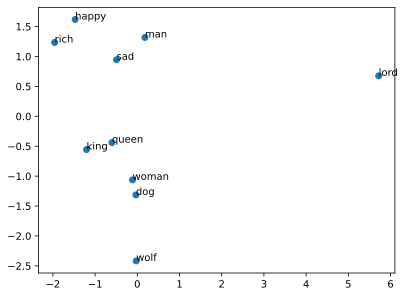

In [131]:
result = compute_pca(EMBS, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()


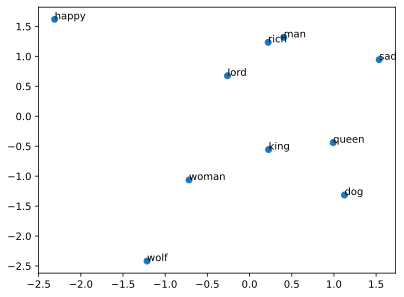

In [132]:
result= compute_pca(EMBS, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()


In [136]:
EMBS.shape # 10 embeddings, each one 50 dimensional

(10, 50)

In [137]:
embs.shape

(5775, 50)